Load Julia packages (libraries) needed

In [1]:
using TuringModels
using Optim, Turing, Flux.Tracker
gr(size=(600,300));

In [2]:
Turing.setadbackend(:reverse_diff);
Turing.turnprogress(false);

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /Users/rob/.julia/packages/Turing/FTRCE/src/Turing.jl:24


### snippet 2.8t

Define the data

In [3]:
k = 6; n = 9;

Define the model

In [4]:
@model globe_toss(n, k) = begin
  theta ~ Beta(1, 1) # prior
  k ~ Binomial(n, theta) # model
  return k, theta
end;

Compute the "maximum_a_posteriori" value

Set search bounds

In [5]:
lb = [0.0]; ub = [1.0];

Create (compile) the model

In [6]:
model = globe_toss(n, k);

Use Turing mcmc

In [7]:
chn = sample(model, NUTS(2000, 200, 0.65));

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/support/hmc_core.jl:240
[NUTS{Turing.Core.FluxTrackerAD,Union{}}] found initial ϵ: 1.6
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/support/hmc_core.jl:235
┌ Warning: 30.233553739684915 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/adapt/stepsize.jl:96
┌ Warning: 7.889099062323837 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/adapt/stepsize.jl:96
┌ Warning: 12.881532937048835 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/adapt/stepsize.jl:96
┌ Warning: 8.289745271919905 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/FTRCE/src/inference/adapt

Look at the generated draws (in chn)

In [8]:
describe(chn)

Iterations = 1:2000
Thinning interval = 1
Chains = 1
Samples per chain = 2000

Empirical Posterior Estimates:
              Mean          SD        Naive SE        MCSE         ESS   
  lf_num  0.0000000000 0.000000000 0.00000000000 0.00000000000        NaN
 elapsed  0.0009203908 0.019374942 0.00043323687 0.00053146813 1329.00426
 epsilon  0.8442177908 0.356964087 0.00798195963 0.03100280777  132.57053
   theta  0.6405965970 0.137484143 0.00307423889 0.00466867308  867.19805
      lp -3.3134361300 0.811923828 0.01815516872 0.02476318982 1075.02212
eval_num  7.6440000000 3.521855439 0.07875108168 0.07402133405 2000.00000
  lf_eps  0.8442177908 0.356964087 0.00798195963 0.03100280777  132.57053

Quantiles:
              2.5%           25.0%         50.0%        75.0%        97.5%    
  lf_num  0.00000000000  0.00000000000  0.000000000  0.000000000  0.0000000000
 elapsed  0.00013414527  0.00015407375  0.000361861  0.000407079  0.0008943039
 epsilon  0.51622321694  0.79927206788  0.7992720

Look at the mean and sd

In [9]:
println("\ntheta = $(mean_and_std(chn[:theta][201:2000]))\n")


theta = (0.6411124505123269, 0.1369459043535808)



Fix the inclusion of adaptation samples

In [10]:
chn2 = MCMCChain.Chains(chn.value[201:2000,:,:], names=chn.names)

Object of type "Chains{Float64}"

Iterations = 1:1800
Thinning interval = 1
Chains = 1
Samples per chain = 1800

Union{Missing, Float64}[0.0 0.000286148 … 4.0 0.799272; 0.0 0.000189315 … 4.0 0.799272; … ; 0.0 0.00872679 … 10.0 0.799272; 0.0 0.000333912 … 4.0 0.799272]

Look at the proper draws (in corrected chn2)

In [11]:
describe(chn2)

Iterations = 1:1800
Thinning interval = 1
Chains = 1
Samples per chain = 1800

Empirical Posterior Estimates:
              Mean                 SD                     Naive SE               MCSE          ESS   
  lf_num  0.0000000000 0.00000000000000000000000 0.000000000000000000000000 0.000000000000        NaN
 elapsed  0.0003775024 0.00062802215305404599822 0.000014802624105329726249 0.000029055606  467.18625
 epsilon  0.7992720679 0.00000000000000033315946 0.000000000000000007852644 0.000000000000 1800.00000
   theta  0.6411124505 0.13694590435358081070838 0.003227845920804711145335 0.005185955729  697.33343
      lp -3.3029052765 0.75906982615514806411738 0.017891447382279965921947 0.026352256957  829.71286
eval_num  7.6133333333 2.93745057791973174232680 0.069236374101579511997073 0.077997821320 1418.32642
  lf_eps  0.7992720679 0.00000000000000033315946 0.000000000000000007852644 0.000000000000 1800.00000

Quantiles:
              2.5%          25.0%         50.0%          75.0%

Compute at hpd region

In [12]:
bnds = MCMCChain.hpd(chn2[:, 4, :], alpha=0.06);

analytical calculation

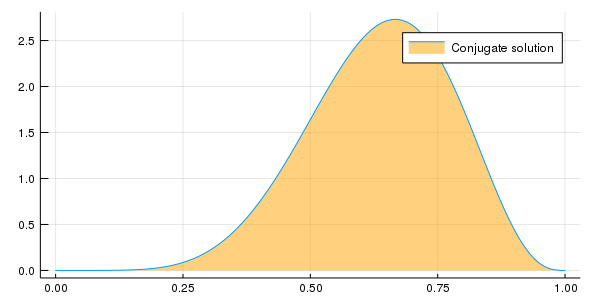

In [13]:
w = 6; n = 9; x = 0:0.01:1
plot( x, pdf.(Beta( w+1 , n-w+1 ) , x ), fill=(0, .5,:orange), lab="Conjugate solution")

quadratic approximation

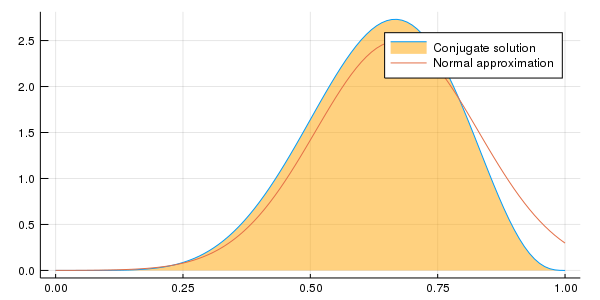

In [14]:
plot!( x, pdf.(Normal( 0.67 , 0.16 ) , x ), lab="Normal approximation")

Turing Chain &  89%hpd region boundaries

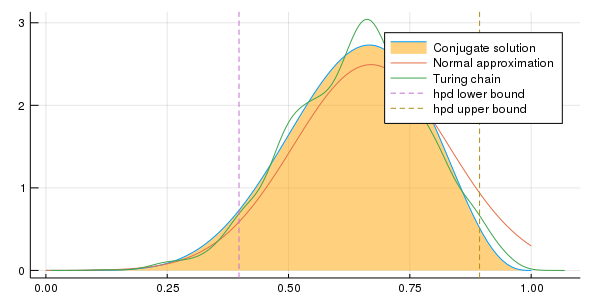

In [15]:
#tmp = convert(Array{Float64,3}, chn.value[:, 4, :])
#draws = reshape(tmp, (size(tmp, 1)*size(tmp, 3)),)
density!(chn.value[:, 4, 1], lab="Turing chain")
vline!([bnds.value[1]], line=:dash, lab="hpd lower bound")
vline!([bnds.value[2]], line=:dash, lab="hpd upper bound")

Show hpd region

In [16]:
println("hpd bounds = $bnds\n")

hpd bounds =        94% Lower  94% Upper
theta 0.39801135 0.89371587





End of `clip_08t.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*